In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import torch
import matplotlib.pyplot as plt
from flipper_training.engine.engine_config import PhysicsEngineConfig
from flipper_training.engine.robot_model import RobotModelConfig
from flipper_training.engine.engine import DPhysicsEngine, PhysicsState, PhysicsStateDer
from flipper_training.utils.dynamics import *
from flipper_training.utils.geometry import *
from flipper_training.utils.environment import *
from flipper_training.utils.numerical import *

In [3]:
from flipper_training.vis.pltvis import *

In [4]:
# Heightmap setup - use torch's XY indexing !!!!!
grid_res = 0.05  # 5cm per grid cell
max_coord = 6.4  # meters
DIM = int(2 * max_coord / grid_res)
xint = torch.linspace(-max_coord, max_coord, DIM)
yint = torch.linspace(-max_coord, max_coord, DIM)
x, y = torch.meshgrid(xint, yint, indexing='xy')

In [5]:
num_robots = 2

In [6]:
# gaussian hm
z = (1.0 * torch.exp(-0.5 * ((x - 0)**2 + (y - 4)**2)) +
     0.0 * torch.exp(-0.3 * ((x - 1)**2 + (y + 2)**2)) +
     1.0 * torch.exp(-0.1 * ((x + max_coord)**2 + (y + max_coord)**2))
     ) + 0.01 * torch.randn_like(x) + torch.exp(-0.03 * ((x + 5)**2 + (y + 5)**2))
x_grid = x.repeat(num_robots, 1, 1)
y_grid = y.repeat(num_robots, 1, 1)
z_grid = z.repeat(num_robots, 1, 1)
x_grid.shape

torch.Size([2, 256, 256])

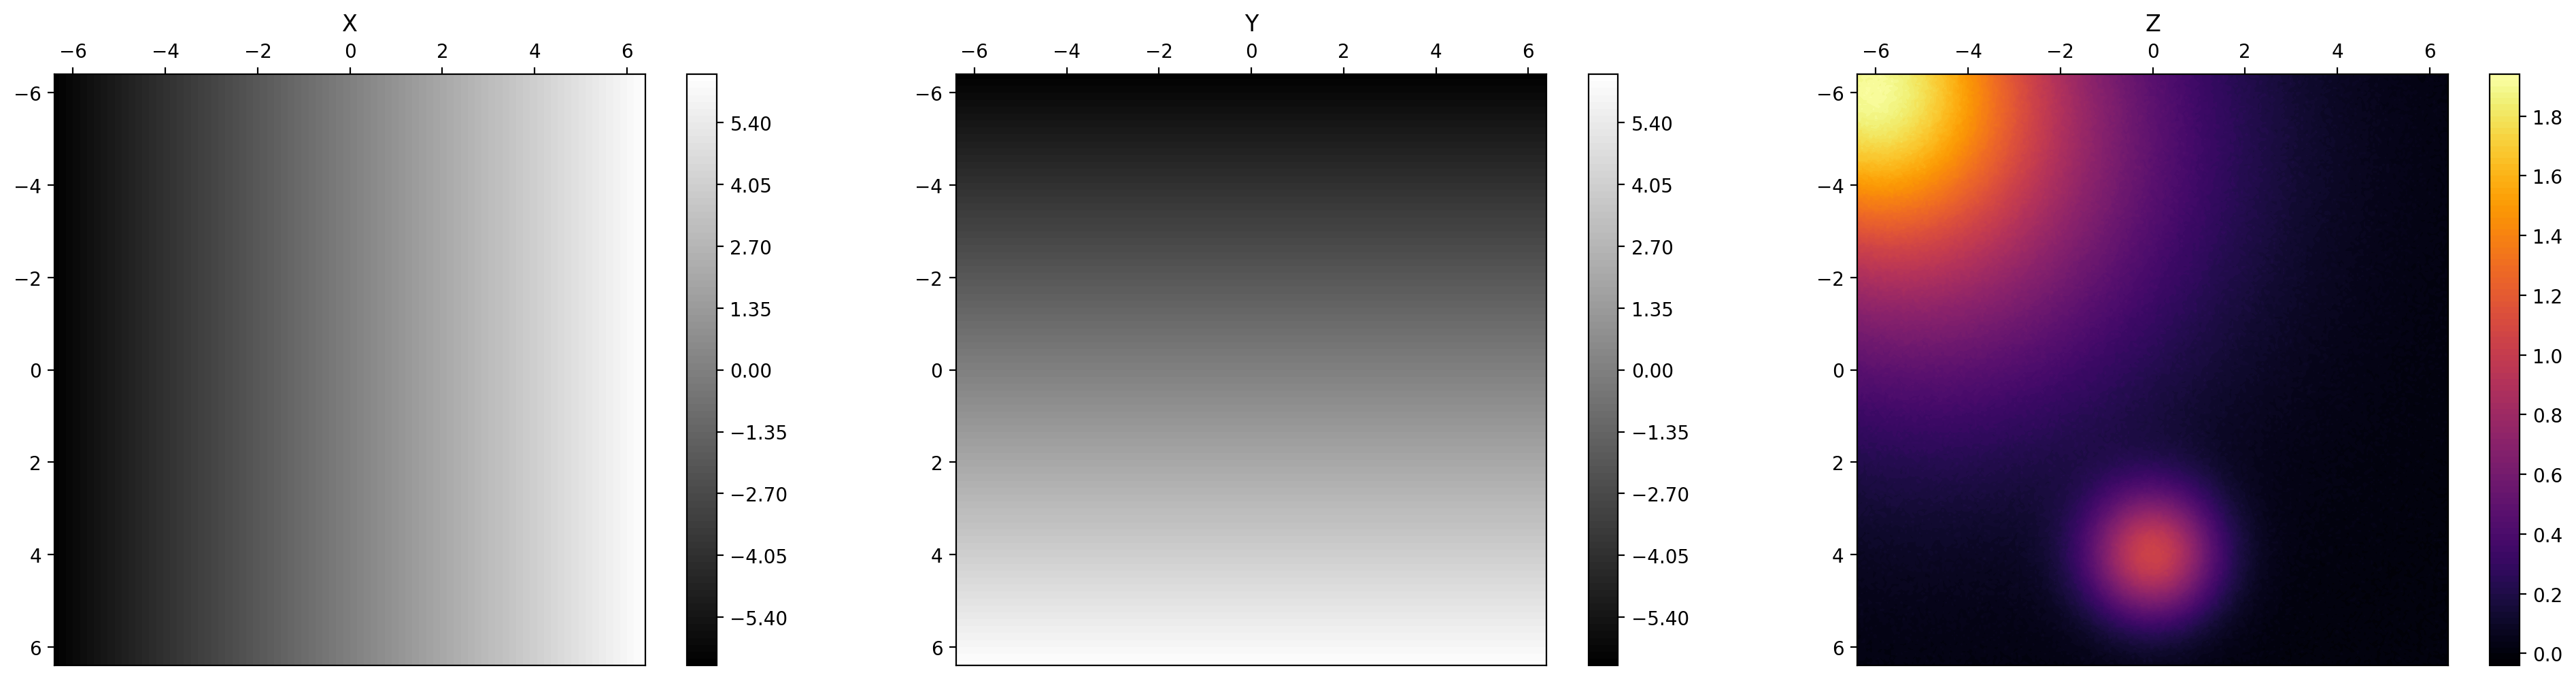

In [7]:
plot_grids_xyz(x_grid[0], y_grid[0], z_grid[0])

In [8]:
# Instatiate the physics config
robot_model = RobotModelConfig(robot_type="marv", voxel_size=0.08, points_per_driving_part=100)
physics_config = PhysicsEngineConfig(robot_model=robot_model, x_grid=x_grid, y_grid=y_grid, z_grid=z_grid, grid_res=grid_res, max_coord=max_coord)

Loading robot model from cache: /Users/davidkorcak/Documents/ctu/bachelors/flipper_training/.cache/marv_0.080_100.pt


In [129]:
# Controls
traj_length = 15.0  # seconds
n_iters = int(traj_length / physics_config.dt)
speed = 0.8  # m/s forward
omega = -0.5  # rad/s yaw
controls = physics_config.robot_model.get_controls(speed, omega)
flipper_controls = torch.zeros_like(controls)

In [130]:
device = "cpu"
engine = DPhysicsEngine(physics_config, device)

In [131]:
x = torch.tensor([-6, -6, 2.]).to(device).repeat(num_robots, 1)
xd = torch.zeros_like(x)
R = torch.eye(3).to(device).repeat(num_robots, 1, 1)
omega = torch.zeros_like(x)
thetas = torch.zeros(num_robots, 4).to(device)
local_robot_points = physics_config.robot_model.robot_points.to(device).repeat(num_robots, 1, 1)
controls_all = torch.cat((controls, flipper_controls)).unsqueeze(0).repeat(n_iters, num_robots, 1).to(device)

In [132]:
# Set joint rotational velocities, we want to follow a sine wave, so we set the joint velocities to the derivative of the sine wave
# We want to go +- pi/6 5 times in 10 seconds
amplitude = torch.pi / 3
periods = 2
rot_vels = torch.cos(torch.linspace(0, periods * 2 * np.pi, n_iters)) * amplitude
rot_vels = rot_vels.unsqueeze(-1).repeat(1, num_robots)
controls_all[:, :, len(controls)] = rot_vels
controls_all[:, :, len(controls) + 1] = rot_vels
controls_all[:, :, len(controls) + 2] = -rot_vels
controls_all[:, :, len(controls) + 3] = -rot_vels

In [133]:
init_state = PhysicsState(x, xd, R, local_robot_points, omega, thetas)

In [134]:
# run all torch compilation
_ = engine(init_state, controls_all[0])

In [135]:
from copy import deepcopy
from collections import deque

In [136]:
states = deque(maxlen=n_iters)
dstates = deque(maxlen=n_iters)
auxs = deque(maxlen=n_iters)

In [137]:
%%time 
state = deepcopy(init_state)
for ctrl in controls_all:
    state, der, aux = engine(state, ctrl)
    states.append(state)
    dstates.append(der)
    auxs.append(aux)

CPU times: user 13.4 s, sys: 2.96 s, total: 16.4 s
Wall time: 2.5 s


In [138]:
from flipper_training.engine.engine_state import vectorize_iter_of_tensor_tuples

In [139]:
states_vec = vectorize_iter_of_tensor_tuples(states)
dstates_vec = vectorize_iter_of_tensor_tuples(dstates)
aux_vec = vectorize_iter_of_tensor_tuples(auxs)

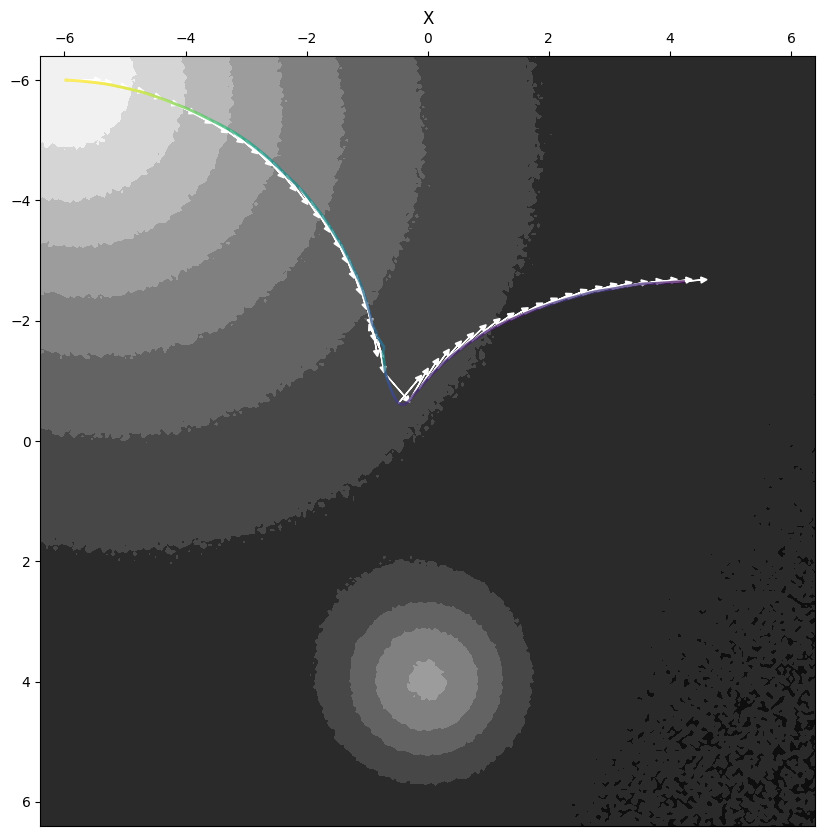

In [140]:
from matplotlib.collections import LineCollection

ROBOT_IDX = 0
ITERSTEP = 30
x_vis = x_grid[ROBOT_IDX].cpu().numpy()
y_vis = y_grid[ROBOT_IDX].cpu().numpy()
z_vis = z_grid[ROBOT_IDX].cpu().numpy()

# Heightmap plot
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
ax.contourf(x_vis, y_vis, z_vis, cmap='gray')
ax.invert_yaxis()
ax.set_title("X")
ax.xaxis.tick_top()  # Move X-axis ticks to the top
ax.tick_params(axis='x', labeltop=True, labelbottom=False)  # Show labels on top and hide them on bottom
xs, ys, zs = states_vec.x[:, ROBOT_IDX, :].T

for i in range(0, len(states_vec.x), ITERSTEP):
    pos = states_vec.x[i, ROBOT_IDX]
    yaw = yaw_from_R(states_vec.R[i, ROBOT_IDX].cpu())
    # plt.text(*pos[:2], str(i), fontsize=12, color='white')
    plt.arrow(*pos[:2], 0.5 * torch.cos(yaw), 0.5 * torch.sin(yaw), head_width=0.1, head_length=0.1, fc='w', ec='w')

np_points = np.array([xs, ys]).T.reshape(-1, 1, 2)
segments = np.concatenate([np_points[:-1], np_points[1:]], axis=1)
lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(min(zs), max(zs)))
lc.set_array(np.array(zs))
lc.set_linewidth(2)
line = ax.add_collection(lc)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'surface'}]])

# World

fig.add_trace(
go.Surface(x=x_vis, y=y_vis, z=z_vis, colorscale='Viridis', showscale=False),
row=1, col=1
)

# Trajectory

fig.add_trace(
go.Scatter3d(x=xs, y=ys, z=zs, mode='lines', line=dict(color='red', width=5)),
)

# Robot pointcloud in last state

pts_global = aux_vec.robot_points[-1, ROBOT_IDX].cpu().numpy()
fig.add_trace(
go.Scatter3d(x=pts_global[..., 0], y=pts_global[..., 1], z=pts_global[..., 2], mode='markers', marker=dict(size=5, color='blue')),
)

fig.update_layout(
scene=dict(
xaxis_title='X',
yaxis_title='Y',
zaxis_title='Height (Z)',
camera_eye=dict(x=1.25, y=1.25, z=1.25),
aspectmode='manual',
aspectratio=dict(
x=1.,
y=1.,
z=z_vis.max().item() / (2 \* max_coord)
),
),
title_text='3D Heightmap',
)
fig.update_layout(
width=1000,
height=1000,
margin=dict(l=20, r=20, t=20, b=20)
)


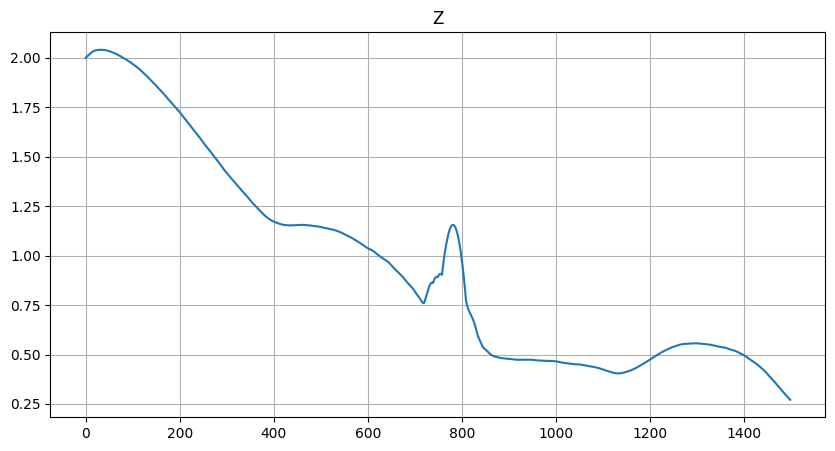

In [141]:
plt.figure(figsize=(10, 5), dpi=100)
plt.grid()
plt.title("Z")
plt.plot(zs)

In [142]:
from flipper_training.vis.visualizer import animate_trajectory

In [144]:
animate_trajectory(physics_config, states, auxs, 0)

: 